In [1]:
!pip install xgboost

In [2]:
!pip install graphviz

# CSCE 633 :: Machine Learning :: Texas A&M University :: Fall 2023

# Homework 2 (HW-2)
**Name: Ayushri Jain**  
**UIN: 934003177**  
**Due on Thur, Oct 26, by 11:59 PM.**

* Please finish your homework in this file with **Python**.
* For your submission please name the files with ***last name_first name_hw2_csce633***. No late submissions accepted.
* You're free to change the definition of the methods and the name of the methods within each class.
* You may also add any number of additional code blocks that you deem necessary.
* You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
* Do **NOT** forget to type in your name and UIN at the beginning of the notebook.
* This is an individual assignment.
* SHOW YOUR WORK.


In [3]:
# References used
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# https://online.stat.psu.edu/stat857/node/155/
# https://www.markdownguide.org/extended-syntax/
# https://arxiv.org/pdf/1603.02754.pdf

# Import the libraries here
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from typing import Tuple
import matplotlib.pyplot as plt
import xgboost as xgb

## Part A - Regularization

### A-1: Read Data

In [4]:
file_path = "./Hitters-1.csv"
df = pd.read_csv(file_path)

### A-2: Data Pre-processing

In [5]:
## YOUR CODE HERE
# Print the shape of the DataFrame 'df' to display the number of rows and columns
print("Shape of data is: {}".format(df.shape))

# Remove rows with missing data (NaN) from the DataFrame in-place
df.dropna(inplace=True)

# Print the shape of the DataFrame 'df' after dropping rows with missing data
print("Shape after dropping rows with missing data : {}".format(df.shape))

# The 'Player' feature is unique for each player (so redundant) and 'NewLeague' is the target variable.
# Create the feature matrix 'features' by dropping 'NewLeague' and 'Player' columns from the DataFrame 'df'
features = df.drop(['NewLeague','Player'], axis=1)

# Store the 'NewLeague' column as the target variable 'labels'
labels = df['NewLeague']

# Select numerical features (int64 and float64 data types) and store them in 'numerical_df'
numerical_df = features.select_dtypes(include = ['int64', 'float64'])

# Select non-numerical (categorical) features, excluding int64 and float64 data types, and store them in 'non_numerical_df'
non_numerical_df = features.select_dtypes(exclude = ['int64', 'float64'])

# Convert categorical features into one-hot encoded format
non_numerical_df = pd.get_dummies(non_numerical_df)

# Concatenate numerical and one-hot encoded categorical features to create the final feature matrix 'features'
features = pd.concat([numerical_df, non_numerical_df], axis = 1)

# Replace categorical labels 'A' with 0 and 'N' with 1 in the 'labels' column
labels = labels.replace({'A': 0, 'N': 1})

Shape of data is: (322, 21)
Shape after dropping rows with missing data : (263, 21)


### A-3: Splitting Data

In [6]:
## YOUR CODE HERE
# Step 1: Split the data into temporary training (60%) and test (40%) sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
# Step 2: Split the temporary training set into validation (40%) and final training (60%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.4, random_state=42)

# Print the shapes of the datasets to verify the split
print(f"Training data   : X_train : {X_train.shape}  , y_train : {y_train.shape}")
print(f"Validation data : X_val   : {X_val.shape}  , y_val   : {y_val.shape}")
print(f"Testing data    : X_test  : {X_test.shape} , y_test  : {y_test.shape}")

Training data   : X_train : (94, 21)  , y_train : (94,)
Validation data : X_val   : (63, 21)  , y_val   : (63,)
Testing data    : X_test  : (106, 21) , y_test  : (106,)


### A-4: Train Ridge

In [7]:
# Define a function for training a Ridge Regression model
def train_ridge( x_train: np.ndarray, y_train:np.ndarray, x_val: np.ndarray, y_val: np.ndarray, max_iter: int = int(1e8))-> dict:
    '''
        Instantiate an object of Ridge Regression, train the model object using training data for the given N-bootstraps iterations.
        In each iteration train the model for all alpha_vals, compute the auc values with the validation set and append the values to aucs_ridge.
        Return the "ridge_mean_auc" dictionary which stores the mean auc for each alpha.
    '''
    # Define the number of bootstraps
    n_bootstraps = int(1e3)
    
    # Create an empty list to store AUC values for different alpha values
    aucs_ridge = []
    
    # Define a list of alpha values to be tested
    alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

    ## YOUR CODE HERE
    # Create an empty dictionary to store mean AUC values for each alpha
    ridge_mean_auc = {}

    # Loop through each alpha value
    for alpha in alpha_vals:
        # Create an empty list to store AUC values for different bootstrap iterations
        aucs = []

        # Perform bootstrapping for n_bootstraps iterations
        for _ in range(n_bootstraps):
            # Create a Ridge model with the current alpha value
            ridge = Ridge(alpha=alpha, max_iter=max_iter)

            # Train the Ridge model on the training data
            ridge.fit(x_train, y_train)

            # Make predictions on the validation set
            y_pred = ridge.predict(x_val)

            # Calculate the AUC (Area Under the ROC Curve) for this iteration
            auc = roc_auc_score(y_val, y_pred)
            
            # Append the AUC value to the list
            aucs.append(auc)

        # Calculate the mean AUC for the current alpha value
        mean_auc = np.mean(aucs)
        
        # Store the mean AUC value in the dictionary with the current alpha as the key
        ridge_mean_auc[alpha] = mean_auc

    # Return the dictionary containing the mean AUC values for each alpha
    return ridge_mean_auc

# Call the function and obtain the dictionary of mean AUC values with maximum iterations allowed = 1000000
ridge_mean_auc_dict = train_ridge(X_train, y_train, X_val, y_val, 1000000)

# Find the alpha value that corresponds to the maximum mean AUC from the dictionary
ridge_optimal_alpha = max(ridge_mean_auc_dict, key = ridge_mean_auc_dict.get)

# Print the optimal alpha value for Ridge Regression
print(f"Optimal value of alpha is {ridge_optimal_alpha} for ridge regression.")

Optimal value of alpha is 1 for ridge regression.


#### Please describe your hyperparameter tuning procedures and the optimal lambda that gives the best model below:

Answer.

From multiple linear regression we have the coefficient estimate 

$$\hat{\beta} = (X^TX)^{-1}X^TY$$

which we can rewrite as 
$$[(X^TX)^{-1}X^T]^{-1}\hat{\beta} = Y$$

$\hat{\beta}$ is a least squares solution of the equation system $X\beta = Y$ iff
$$\forall \beta \in \mathbb{R}^n \ \|Y - X\hat{\beta}\| \le \|Y - X\beta\|$$


Regularization is a method for solving overfitting. It involves introducing additional information to a model in the form of a penalty. The penalty imposes a shrinkage on the coefficient estimates of ordinary least squares. The Ridge Regression cost function consists of two terms:
1. The mean squared error term, which measures the model's ability to fit the training data.
2. The regularization term, which is a penalty term based on the L2 norm of the model parameters. It discourages the parameters from taking very large values.


Given the sum of square error estimate for least squares we have $(Y-X\beta)^T(Y-X\beta)$.

Ridge regression adds the $L_2$ penalty such that we have our loss function as

$$L = (Y-X\beta)^T(Y-X\beta) + \alpha\beta^T\beta$$

Derive the ridge coefficient estimate:
$$(Y-X\beta)^T(Y-X\beta) + \alpha\beta^T\beta$$
$$=(Y^T-\beta^TX^T)(Y-X\beta) + \alpha\beta^T\beta$$
$$=Y^TY - Y^TX\beta - \beta^TX^TY + \beta^TX^TX\beta + \alpha\beta^T\beta$$
$$=Y^TY - 2Y^TX\beta + \beta^TX^TX\beta + \alpha\beta^T\beta$$
$$\rightarrow \frac{d}{d\beta} = 0 - 2Y^TX + 2X^TX\beta + 2\alpha\beta = 0$$

$$\implies\hat{\beta}_{ridge} = (X^TX + \alpha I)^{-1}X^TY$$

$\alpha \ge 0$ is a tuning parameter for the penalty. 

* When $\alpha = 0$ we have the ordinary least squares estimate.
* When $\alpha \rightarrow \infty$ all the coefficients approach zero.
* Thus, we need a procedure to select the optimal alpha value.

The goal of hyperparameter tuning in Ridge Regression is to find the optimal regularization parameter $\alpha$, that maximizes the model's performance, typically measured by a suitable evaluation metric. In this case, the evaluation metric is the Area Under the ROC Curve (AUC).

To find the optimal $\alpha$, I have followed these steps:

1. A list of candidate $\alpha$ values, $\alpha_{\text{vals}}$, is predefined. These values cover a range from very small to very large $\alpha$ values, effectively controlling the amount of regularization applied.

2. For each $\alpha$ in $\alpha_{\text{vals}}$, the code performs bootstrapping, which creates multiple bootstrap training sets by sampling with replacement from the original training data.

3. For each bootstrap iteration and $\alpha$ value, a Ridge Regression model is trained using the cost function defined above.

4. Predictions are made on the validation set, and the area under the curve (AUC) is calculated for that iteration.

5. The mean AUC is computed by averaging the AUC values obtained from multiple bootstrap iterations for a given $\alpha$.

6. The optimal $\alpha$, denoted as $\alpha_{\text{opt}}$, is selected as the $\alpha$ value that maximizes the mean AUC on the validation set:

$
\alpha_{\text{opt}} = \arg\max_{\alpha} \text{mean AUC}(\alpha)
$

7. The $\alpha_{\text{opt}}$ value represents the regularization parameter that results in the best model performance in terms of AUC on the validation set. This optimal $\alpha$ balances the trade-off between fitting the training data and preventing overfitting.

#### Optimal value of alpha is 1 for ridge regression.

### A-5: Train Lasso

In [8]:
# Define a function for training a Lasso Regression model with hyperparameter tuning
def train_lasso( x_train: np.ndarray, y_train:np.ndarray, x_val: np.ndarray, y_val: np.ndarray, max_iter: int = int(1e8))-> dict:
    '''
        Instantiate an object of Lasso Regression Model. Train the model object using training data for the given N-bootstraps iterations.
        In each iteration train the model for all alpha_vals, compute the auc values with the validation set and append the values to aucs_lasso.
        Return the "lasso_mean_auc" dictionary which stores the mean auc for each alpha.
    '''
    
    # Define the number of bootstraps
    n_bootstraps = int(1e3)
    
    # Create an empty list to store AUC values for different alpha values
    aucs_lasso = []
    
    # Define a list of alpha values to be tested
    alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

    ## YOUR CODE HERE
    # Create an empty dictionary to store mean AUC values for each alpha
    lasso_mean_auc = {}

    # Loop through each alpha value
    for alpha in alpha_vals:
        # Create an empty list to store AUC values for different bootstrap iterations
        aucs = []

        # Perform bootstrapping for n_bootstraps iterations
        for _ in range(n_bootstraps):
            # Create a Lasso model with the current alpha value
            lasso = Lasso(alpha=alpha, max_iter=max_iter)

            # Train the Lasso model on the training data
            lasso.fit(x_train, y_train)

            # Predict on the validation set
            y_pred = lasso.predict(x_val)

            # Calculate the AUC (Area Under the ROC Curve) for this iteration
            auc = roc_auc_score(y_val, y_pred)
            
            # Append the AUC value to the list
            aucs.append(auc)

        # Calculate the mean AUC for the current alpha value
        mean_auc = np.mean(aucs)
        
        # Store the mean AUC value in the dictionary with the current alpha as the key
        lasso_mean_auc[alpha] = mean_auc

    # Return the dictionary containing the mean AUC values for each alpha
    return lasso_mean_auc

# Call the function and obtain the dictionary of mean AUC values
lasso_mean_auc_dict = train_lasso(X_train, y_train, X_val, y_val, 1000000)

# Find the alpha value that corresponds to the maximum mean AUC
lasso_optimal_alpha = max(lasso_mean_auc_dict, key = lasso_mean_auc_dict.get)

# Print the optimal alpha value for Lasso Regression
print(f"Optimal value of alpha is {lasso_optimal_alpha} for lasso regression.")

Optimal value of alpha is 0.01 for lasso regression.


#### Please describe your hyperparameter tuning procedures and the optimal alpha that gives the best model below:

Answer. In this function, hyperparameter tuning is performed for the Lasso Regression model similar to Ridge above. The steps include looping through each alpha value, training the Lasso model multiple times, calculating AUC values, and storing the mean AUC values for each alpha in the lasso_mean_auc dictionary.
**The alpha value with maximum AUC value will be the optimal value alpha.**


The LASSO model can be shown in the same form as we derived equation for Ridge Regression above:

$$(Y-X\beta)^T(Y-X\beta) + \alpha|\beta|_1$$

Where $|\beta|_1 = \sum\limits_{j=1}^{p}|\beta|_j$.
The only difference is that LASSO uses the $L_1$ penalty instead of the $L_2$ penalty. The largest benefit of LASSO is the model's ability to create sparse matrices.

$\alpha \ge 0$ is a tuning parameter for the penalty. 

* When $\alpha = 0$ we have the ordinary least squares estimate.
* When $\alpha \rightarrow \infty$ all the coefficients approach zero.
* Thus, we need a procedure to select the optimal alpha value.

The goal of hyperparameter tuning in LASSO Regression is to find the optimal regularization parameter $\alpha$, that maximizes the model's performance, typically measured by a suitable evaluation metric. In this case, the evaluation metric is the Area Under the ROC Curve (AUC).

To find the optimal $\alpha$, I have followed these steps:

1. A list of candidate $\alpha$ values, $\alpha_{\text{vals}}$, is predefined. These values cover a range from very small to very large $\alpha$ values, effectively controlling the amount of regularization applied.

2. For each $\alpha$ in $\alpha_{\text{vals}}$, the code performs bootstrapping, which creates multiple bootstrap training sets by sampling with replacement from the original training data.

3. For each bootstrap iteration and $\alpha$ value, a LASSO Regression model is trained using the cost function defined above.

4. Predictions are made on the validation set, and the area under the curve (AUC) is calculated for that iteration.

5. The mean AUC is computed by averaging the AUC values obtained from multiple bootstrap iterations for a given $\alpha$.

6. The optimal $\alpha$, denoted as $\alpha_{\text{opt}}$, is selected as the $\alpha$ value that maximizes the mean AUC on the validation set:

$\alpha_{\text{opt}} = \arg\max_{\alpha} \text{mean AUC}(\alpha)$

7. The $\alpha_{\text{opt}}$ value represents the regularization parameter that results in the best model performance in terms of AUC on the validation set. This optimal $\alpha$ balances the trade-off between fitting the training data and preventing overfitting.

#### Optimal value of alpha is 0.01 for lasso regression.

### A-6: Ridge Coefficients

In [9]:
# Define a function to return a tuple of a trained Ridge model and its coefficients
def ridge_coefficients(x_train: np.ndarray, y_train:np.ndarray, optimal_alpha:float, max_iter=int(1e8)) -> Tuple[Ridge, np.ndarray]:
    '''
        Return a tuple consisting of trained Ridge model with alpha as optimal_alpha and the coefficients of the model
    '''
    ########################
    ## Your Solution Here ##
    ########################
    # Create a Ridge model with the optimal alpha and max_iter
    ridge_model = Ridge(alpha=optimal_alpha, max_iter=max_iter)
    
    # Fit the model to the training data
    ridge_model.fit(x_train, y_train)
    
    # Get the coefficients of the trained model
    coefficients = ridge_model.coef_
    
    # Return a tuple containing the Ridge model and its coefficients
    return (ridge_model, coefficients)

# Call the function to obtain the trained Ridge model and its coefficients
ridge_model, ridge_coeffs = ridge_coefficients(X_train, y_train, ridge_optimal_alpha)

# Print the coefficients of the Ridge model
print(ridge_coeffs)

[ 8.17593296e-04 -1.00929854e-03  6.25700617e-03 -8.89455060e-04
 -4.10733577e-03  9.61849680e-05  6.48177152e-03 -4.68478413e-04
  1.21359629e-03 -6.33329375e-04  1.29897584e-04  7.53319081e-04
  1.70668134e-04  1.02009314e-05  1.14546743e-04 -1.53284717e-03
 -5.46938727e-06 -4.32379873e-01  4.32379873e-01 -4.59576343e-02
  4.59576343e-02]


### A-7: Lasso Coefficients

In [10]:
def lasso_coefficients(x_train: np.ndarray, y_train:np.ndarray, optimal_alpha:float, max_iter=int(1e8)) -> Tuple[Lasso, np.ndarray]:
    '''
        Return a tuple consisting of trained Lasso model with alpha as optimal_alpha and the coefficients of the model
    '''
    ########################
    ## Your Solution Here ##
    ########################
    # Create a Lasso model with the optimal alpha and max_iter
    lasso_model = Lasso(alpha=optimal_alpha, max_iter=max_iter)
    
    # Fit the model to the training data
    lasso_model.fit(x_train, y_train)
    
    # Get the coefficients of the trained model
    coefficients = lasso_model.coef_
    
    # Return a tuple containing the Lasso model and its coefficients
    return (lasso_model, coefficients)

# Call the function to obtain the trained Lasso model and its coefficients
lasso_model, lasso_coeffs = lasso_coefficients(X_train, y_train, lasso_optimal_alpha)

# Print the coefficients of the Lasso model
print(lasso_coeffs)

[ 7.62870050e-04 -1.03687653e-03  4.43450802e-03 -6.61727451e-04
 -3.61108268e-03  2.16335723e-04  3.30165261e-03 -4.36251487e-04
  1.29289569e-03 -0.00000000e+00 -8.24211513e-05  4.55100098e-04
  1.87780435e-04  3.45882110e-06  8.00994542e-05 -8.75278472e-04
 -0.00000000e+00 -8.44910013e-01  8.92564636e-14 -4.93981841e-02
  2.36217665e-17]


#### A-8: Compare the coefficients you got from Ridge and Lasso models in this cell.
* Both Ridge and Lasso regression have regularized coefficients, meaning that some coefficients are reduced to nearly zero. 
* Lasso has coefficients that are exactly zero, indicating feature selection. Features with index 9 and 16 have coefficients set to zero in Lasso. Features with non-zero coefficients in Lasso are considered important, while features with zero coefficients are effectively eliminated from the model.
* Ridge coefficients are typically non-zero and distributed continuously between positive and negative values. In the Ridge model, no coefficients become exactly zero.

### A-9: Ridge Area Under Curve

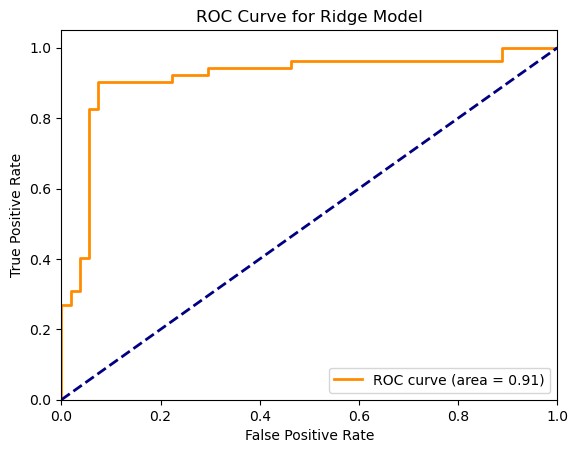

AUC for Ridge Regression: 0.9134615384615385


In [11]:
# Define a function to calculate the Area Under the Curve (AUC) and plot the ROC curve for a trained Ridge model
def ridge_area_under_curve(model_R, x_test: np.ndarray, y_test: np.ndarray) -> float:
    '''
        return area under the curve measurements of trained Ridge model used to find coefficients, i.e., model tarined with optimal_aplha
        Also plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    '''
    ## YOUR CODE HERE
    # Predict on the test set
    y_pred = model_R.predict(x_test)
    
    # Calculate the ROC AUC
    ridge_auc = roc_auc_score(y_test, y_pred)
    
    # Compute ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(ridge_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Ridge Model')
    plt.legend(loc='lower right')
    plt.show()
    
    # Return the calculated ROC AUC
    return ridge_auc

# Call the function to calculate the ROC AUC and plot the ROC curve for the trained Ridge model
ridge_auc = ridge_area_under_curve(ridge_model, X_test, y_test)

# Print the calculated ROC AUC
print(f"AUC for Ridge Regression: {ridge_auc}")

### A-10: Lasso Area Under Curve

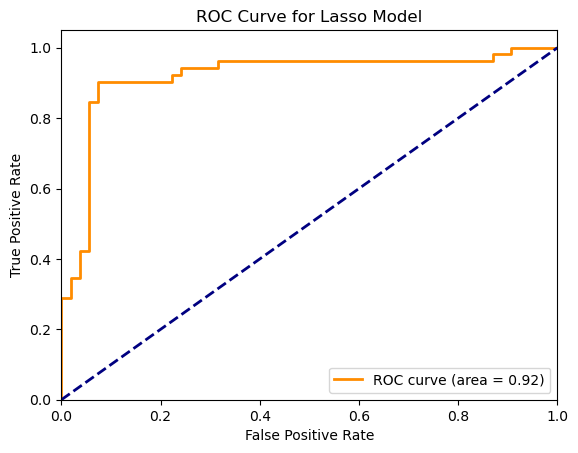

AUC for Lasso Regression: 0.9191595441595443


In [12]:
def lasso_area_under_curve(model_L, x_test: np.ndarray, y_test: np.ndarray) -> float:
    '''
        return area under the curve measurements of Lasso Model, i.e., model tarined with optimal_aplha
        Also plot the ROC Curve using false_positive_rate, true_positive_rate as x and y axes calculated from roc_curve
    '''
    ## YOUR CODE HERE
    # Predict on the test set
    y_pred = model_L.predict(x_test)
    
    # Calculate the ROC AUC
    lasso_auc = roc_auc_score(y_test, y_pred)
    
    # Compute ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(lasso_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Lasso Model')
    plt.legend(loc='lower right')
    plt.show()
    
    # Return the calculated ROC AUC
    return lasso_auc

# Call the function to calculate the ROC AUC and plot the ROC curve for the trained Lasso model
lasso_auc = lasso_area_under_curve(lasso_model, X_test, y_test)

# Print the calculated ROC AUC
print(f"AUC for Lasso Regression: {lasso_auc}")

# Part B- Regression and Classification Trees

### Instructions


In this part, you'll be coding up regression and classification trees from scratch. Trees are a special class of graphs with only directed edges sans any cycles. They fall under the category of directed acyclic graphs or DAGs. So, trees are DAGs where each child node has only one parent node.  
Since trees are easy to design recursively, it is super important that you're familiar with **recursion**. So, it is highly recommended that you brush up on recursion and tree-based search algorithms such as depth-first search (BFS) and breadth-first search (BFS).

### Instructions
- You are **NOT** allowed to use machine learning libraries such as scikit-learn to build regression and classification trees for this section (**ONLY IN THIS SECTION**).
- Download the datasets `noisy_sin_subsample_2.csv` [here](https://github.com/jermwatt/machine_learning_refined/blob/gh-pages/mlrefined_datasets/nonlinear_superlearn_datasets/noisy_sin_subsample_2.csv) and `new_circle_data.csv` [here](https://github.com/jermwatt/machine_learning_refined/blob/gh-pages/mlrefined_datasets/nonlinear_superlearn_datasets/new_circle_data.csv).

Below is a suggested sequence of steps you may want to think along for building regression and classification trees.

1. **Defining a criteria for splitting.**
    1. This criteria assigns a score to a split.
    1. For regression trees, this would be the mean squared error.
    2. For decision trees, this would be the Gini index or entropy.
2. **Create the split.**
    1. Split the dataset by iterating over all the rows and feature columns.
    2. Evaluate all the splits using the splitting criteria.
    3. Choose the best split.
3. **Build the tree.**
    1. Terminal nodes: decide when to stop growing a tree. This would be the maximum allowed depth of the tree or when a leaf is empty or has only 1 element.
    2. Recursive splitting: once a split is created, you can split it further recursively by calling the same splitting function on it.
    3. Building a tree: create a root node and apply recursive splitting on it.
4. **Make predictions with the tree.**
    1. For a given data point, make a prediction using the tree.

#### (1) Growing a maximum-depth regression tree

The recursive procedure for growing a deep regression tree is illustrated in the figure below. We begin (on the left) by fitting a stump to the original dataset. As we move from left to right the recursion proceeds, with each leaf of the preceding tree split in order to create the next, deeper tree. As can be seen in the rightmost panel, a tree with maximum depth of four is capable of representing the training data perfectly.  

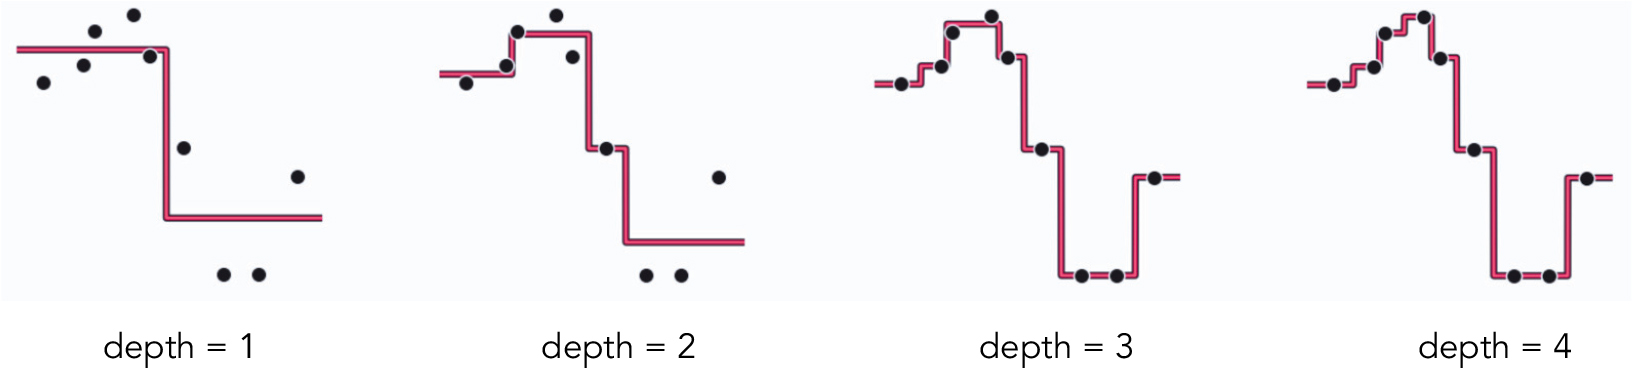

**Peform the experiment shown in the figure by coding up a recursively defined regression tree. Instead of reproducing the plot, measure and plot the mean squared error (MSE) at each depth of your tree.**

In [13]:
csvname = 'noisy_sin_subsample_2.csv' # Place the CSV file in the same directory as this notebook
data_regress = np.loadtxt(csvname, delimiter = ',')
data_regress = np.array([[x, y] for x,y in zip(*data_regress)])

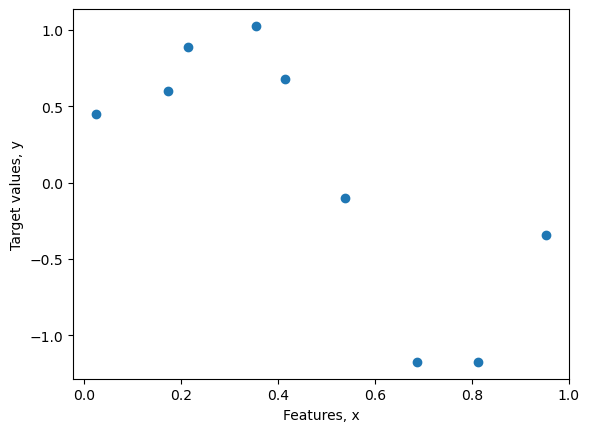

In [14]:
# Plot the data
plt.figure()
plt.scatter(data_regress[:, 0], data_regress[:, 1])
plt.xlabel("Features, x")
plt.ylabel("Target values, y")
plt.show()

**Build the regression tree in the `TreeRegressor` class**.  

In [15]:
class TreeNode():
    # Constructor for TreeNode class
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, mse=None, value=None):
        self.feature_index = feature_index # Index of the feature to split on
        self.threshold = threshold # Threshold value for the feature
        self.left = left # Left subtree (another TreeNode)
        self.right = right # Right subtree (another TreeNode)
        self.mse = mse  # Mean Squared Error associated with this node
        self.value = value  # Value for leaf nodes

class TreeRegressor():
    # Constructor for TreeRegressor class
    def __init__(self, min_samples_split=2, max_depth=2):
        # Initialize the root of the tree to None
        self.root = None
        
        # Stopping conditions:
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.max_depth = 5  # Maximum depth of the tree
        self.mse_at_depth = {}  # Dictionary to store MSE values at different depths

    # Recursive function to build the tree
    def build_tree(self, dataset, curr_depth=0):
        # Extract the input features (X) and target values (Y) from the dataset
        X, Y = dataset[:,:-1], dataset[:,-1]
        
        # Get the number of samples and number of features in the dataset
        num_samples, num_features = np.shape(X)
        
        # Initialize an empty dictionary to store information about the best split
        best_split = {}
        
        # Check if stopping conditions are met for further splitting
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # Find the best split for the current dataset
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            if best_split is not None:
                # Recursively build the left subtree
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                
                # Recursively build the right subtree
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                
                # Store the mean squared error (mse) for the current depth
                self.mse_at_depth[curr_depth + 1] = best_split["mse"]
                
                # Create and return a decision node with split information
                return TreeNode(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["mse"])
        
        # Compute the leaf node value
        leaf_value = self.calculate_leaf_value(Y)

        # Create and return a leaf node with the computed value
        return TreeNode(value = leaf_value)
    
    # Function to find best split
    def get_best_split(self, dataset, num_samples, num_features):        
        # Initialize a dictionary to store the best split
        best_split = {}
        
        # Initialize the minimum mean squared error as positive infinity
        min_mse = float('inf')
        
        # Loop over all the features
        for feature_index in range(num_features):
            # Get the values of the current feature
            feature_values = dataset[:, feature_index]
            
            # Find unique values as possible thresholds
            possible_thresholds = np.unique(feature_values)
            
            # Loop over all the possible threshold values in the data
            for threshold in possible_thresholds:
                # Get the left and right datasets after the split using the current threshold
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                splits = [dataset_left, dataset_right] # 1
                
                # Check if both child datasets are not empty
                if len(dataset_left)>0 and len(dataset_right)>0:
                    # Get the target values for the entire dataset, left dataset, and right dataset
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    # Calculate the mean squared error for the current split
                    mse = self.mean_squared_error(splits)
                    
                    # If the calculated mean squared error is smaller than the current minimum, update the best split information
                    if mse < min_mse:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["mse"] = mse
                        min_mse = mse

        # Return the information about the best split
        return best_split
 

    # Function to split the dataset into left and right based on a feature and threshold
    def split(self, dataset, feature_index, threshold):
        # Create an array of rows from the dataset where the feature value is less than or equal to the threshold
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        
        # Create an array of rows from the dataset where the feature value is greater than the threshold
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        
        # Return the left and right datasets
        return dataset_left, dataset_right

    # Function to calculate the value of a leaf node in the decision tree
    def calculate_leaf_value(self, Y):
        # Calculate the mean value of the target variable Y
        val = np.mean(Y)
        
        # Return the calculated mean value as the leaf node value
        return val

    # Function to train the decision tree
    def fit(self, X, Y):
        # Concatenate the feature matrix X and the target values Y along the columns (axis=1)
        dataset = np.concatenate((X, Y), axis=1)
        
        # Build the decision tree using the concatenated dataset and set it as the root of the tree
        self.root = self.build_tree(dataset)
    
    # Function to make predictions using the trained decision tree
    def _prediction(self, x, tree):
        # If the current tree node has a defined value, return that value (indicating a leaf node)
        if tree.value is not None:
            return tree.value
        
        # Get the feature value of the input data point
        feature_val = x[tree.feature_index]
        
        # If it is less than or equal to the node's threshold, recursively call the function on the left subtree of the tree
        if feature_val<=tree.threshold:
            return self._prediction(x, tree.left)
        
        # If it is greater than the threshold, recursively call the function on the right subtree
        else:
            return self._prediction(x, tree.right)
    
    # Function to predict a list of data points
    def predict(self, X):      
        # Calculate the predictions using the _prediction function
        predictions = [self._prediction(x, self.root) for x in X]
        
        # Return the list of predictions for the input data points
        return predictions
    
    # Function to calculate mean squared error for a list of splits
    def mean_squared_error(self, splits):
        # Initialize a variable to keep track of the total mean squared error
        total_mse = 0
        
        # Iterate through each split in the list of splits
        for split in splits:
            # Check if the split is not empty
            if len(split) > 0:
                # Extract the target values from the split
                target_values = split[:, -1]
                
                # Calculate the mean of the target values
                mean = np.mean(target_values)
                
                # Calculate the mean squared error for the split
                mse = np.mean((target_values - mean) ** 2)
                
                # Add the calculated mean squared error to the total
                total_mse += mse
                
        # Return the total mean squared error for all splits
        return total_mse    
        
# Extract the first column of the 'data_regress' dataset as feature X
X = data_regress[:, 0].reshape(-1,1)

# Extract the second column of the 'data_regress' dataset as target variable Y
Y = data_regress[:, 1].reshape(-1,1)

# Create an instance of the TreeRegressor class with specified parameters
regressor = TreeRegressor(min_samples_split=2, max_depth=10)

# Fit the regressor to the feature X and target Y, training the decision tree
regressor.fit(X,Y)

Don't forget to create a method to make predictions using your tree. You may create a separate function for it or make it a part of the `TreeRegressor` class.  
**Plot the MSE at each depth of your tree**

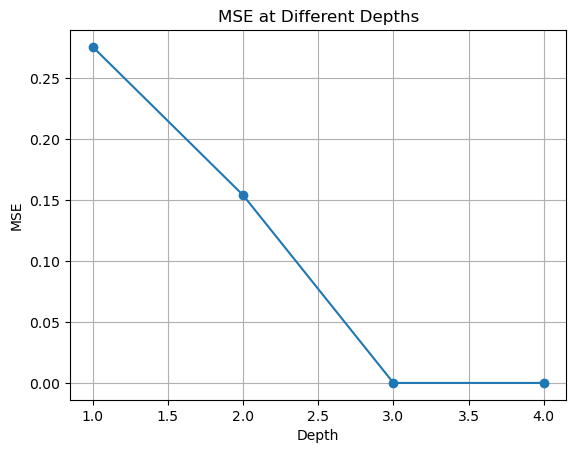

In [16]:
# Convert the MSE data stored as key-value pairs into a NumPy array
mse_array = np.array(list(regressor.mse_at_depth.items()))

# Sort the MSE array based on the depth values (column 0)
mse_array = mse_array[mse_array[:, 0].argsort()]

# Separate the array into x (depth) and y (MSE) values
x_values = mse_array[:, 0]
y_values = mse_array[:, 1]

# Create a line plot with markers
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add labels and title to the plot
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.title('MSE at Different Depths')

# Add grid lines for clarity
plt.grid(True)

# Display the plot
plt.show()

### Growing a two-class classification tree

The figure below shows the growth of a tree to a maximum depth of seven on a two-class classification dataset. As the tree grows, note how many parts of the input space do not change as leaves on the deeper branches become *pure*. By the time we reach a maximum depth of seven, there is considerable overfitting.

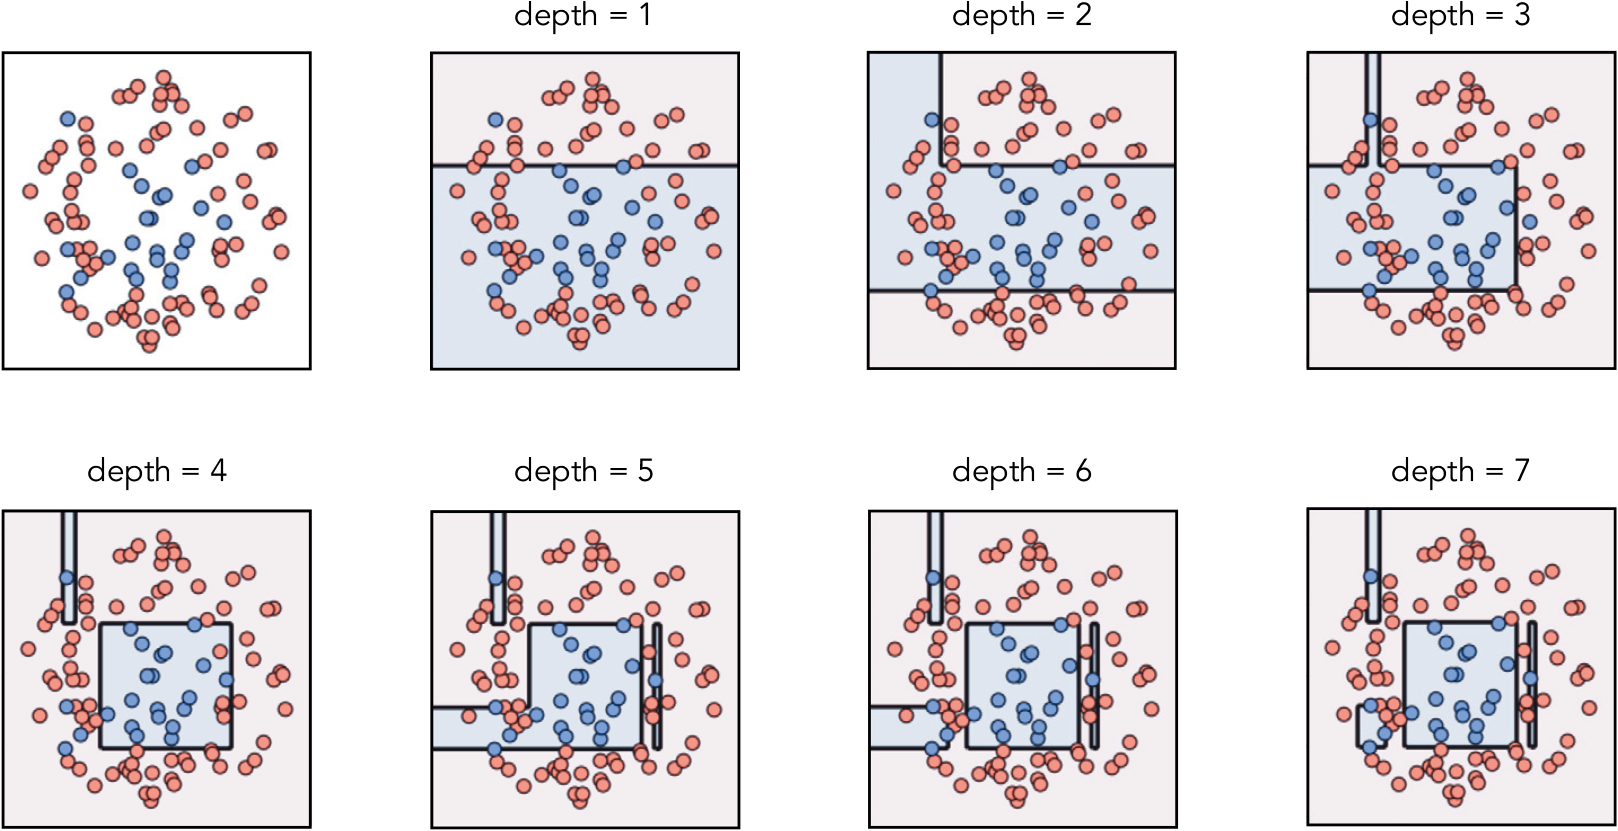

**Perform the experiment shown in figure by coding up a recursively defined two-class classification tree. Instead of reproducing the plot, measure and plot the classification accuracy at each depth of your tree.**

In [17]:
csvname = 'new_circle_data.csv' # Place the CSV file in the same directory as this notebook
data_class = np.loadtxt(csvname, delimiter = ',')
data_class = np.array([[x1, x2, y] for x1,x2,y in zip(*data_class)])

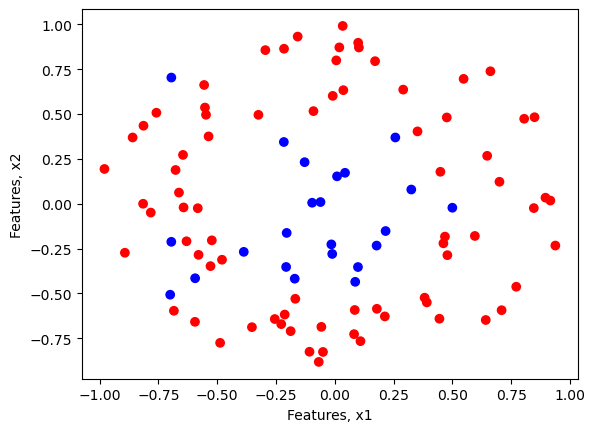

In [18]:
# Plot the data
plt.figure()
plt.scatter(data_class[:, 0], data_class[:, 1], c=-data_class[:, 2], cmap='bwr')
plt.xlabel("Features, x1")
plt.ylabel("Features, x2")
plt.show()

In [19]:
# TreeClassifier is a derived class of TreeRegressor
# Don't forget to create a method to make predictions using your tree.

class TreeClassifier(TreeRegressor):
    def __init__(self, min_samples_split=2, max_depth=2):
        # Call the constructor of the parent class (TreeRegressor) and pass min_samples_split and max_depth
        super().__init__()
        
        # Define stopping conditions for the decision tree
        self.min_samples_split = min_samples_split # Minimum samples required to split a node
        self.max_depth = max_depth # Maximum depth of the tree
    
    # Recursive function to build the tree
    def build_tree(self, dataset, curr_depth=0):
        # Separate the dataset into features (X) and target values (Y)
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # Check if stopping conditions are met (minimum samples or maximum depth)
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # Find the best split for the dataset
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            # Check if the information gain from the split is positive
            if best_split["info_gain"]>0:
                # Recur into building the left subtree
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)

                # Recur into building the right subtree
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                
                # Create a decision node with relevant information
                node = TreeNode(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["info_gain"])
                
                # Return the decision node
                return node

        # Compute a leaf node value
        leaf_value = self.calculate_leaf_value(Y)

        # Return a leaf node with the computed value
        return TreeNode(value=leaf_value)
    
    # Function to find the best split in a decision tree node
    def get_best_split(self, dataset, num_samples, num_features):
        # Initialize a dictionary to store information about the best split
        best_split = {}
        
        # Initialize a variable to track the maximum information gain
        max_info_gain = -float("inf")
        
        # Loop over all the features in the dataset
        for feature_index in range(num_features):
            # Get the values of the current feature
            feature_values = dataset[:, feature_index]
            
            # Find unique values in the feature to consider as potential thresholds
            possible_thresholds = np.unique(feature_values)
            
            # Loop over all the unique feature values as potential thresholds
            for threshold in possible_thresholds:
                # Split the dataset based on the current feature and threshold
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                # Check if both child datasets are not empty
                if len(dataset_left)>0 and len(dataset_right)>0:
                    # Get the target values for the original dataset, left dataset, and right dataset
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    # Compute the information gain for the current split
                    curr_info_gain = self.information_gain(y, left_y, right_y)

                    # Update the best split information if the current split has higher information gain
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # Return the information about the best split found
        return best_split
    
    # Function to calculate information gain
    def information_gain(self, parent, left_child, right_child):
        # Calculate the weight of the left child
        weight_left = len(left_child) / len(parent)
        
        # Calculate the weight of the right child
        weight_right = len(right_child) / len(parent)
        
        # gain = self.entropy(parent) - (weight_left*self.entropy(left_child) + weight_right*self.entropy(right_child))
        # Calculate the information gain by subtracting the weighted gini index of children from the parent entropy
        gain = self.gini_index(parent) - (weight_left*self.gini_index(left_child) + weight_right*self.gini_index(right_child))
        
        # Return the calculated information gain
        return gain
    
#     Function to calculate entropy of a set of target values
#     def entropy(self, y):
#         # Find the unique class labels in the target values
#         class_labels = np.unique(y)
#         entropy = 0
#         # Calculate the entropy by iterating over the unique class labels
#         for cls in class_labels:
#             p_cls = len(y[y == cls]) / len(y) # Probability of a class in the data
#             entropy += -p_cls * np.log2(p_cls) # Calculate entropy for each class        
#         # Return entropy value
#         return entropy

    
    # Function to calculate gini index for a set of target values
    def gini_index(self, y):
        # Find the unique class labels in the target values
        class_labels = np.unique(y)
        gini = 0
        
        # Calculate the gini index by iterating over the unique class labels
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y) # Probability of a class in the data
            gini += p_cls * (1 - p_cls) # Calculate gini index for each class
        
        # Return gini index value
        return gini
    
    # Function to calculate leaf node value
    def calculate_leaf_value(self, Y):
        # Convert Y to a list for easier processing
        Y = list(Y)
        
        # Calculate the leaf value as the most common class in Y (majority voting)
        return max(Y, key=Y.count)
    
    # Function to calculate the accuracy of the model on a dataset
    def calculate_accuracy(self, X, Y, tree):
        # Make predictions using the trained tree on input data
        predictions = [self._prediction(x, tree) for x in X]
        
        # Count the number of correct predictions
        correct_predictions = sum(predictions[i] == Y[i] for i in range(len(Y)))
        
        # Calculate accuracy as the ratio of correct predictions to the total number of data points
        accuracy = correct_predictions / len(Y)
        
        # Return calculated accuracy
        return accuracy
        

**Plot the classification accuracy at each depth of your tree.**

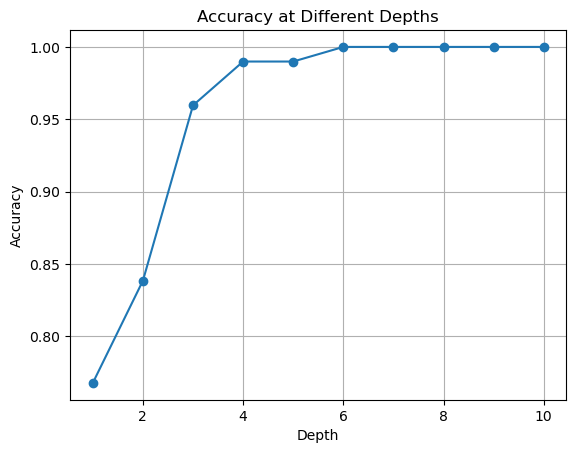

In [20]:
## YOUR CODE HERE

# Create an empty list to store accuracy values
accuracy_array = []

# Loop through different max_depth values from 1 to 10
for i in range(1, 11):
    # Create a TreeClassifier with the specified max_depth and min_samples_split
    clf = TreeClassifier(min_samples_split=2, max_depth=i)
    
    # Fit the classifier to the data
    clf.fit(data_class[:,:-1], data_class[:,-1].reshape(-1,1))
    
    # Calculate accuracy and append it to the accuracy_array
    accuracy_array.append(clf.calculate_accuracy(data_class[:,:-1], data_class[:,-1].reshape(-1,1), clf.root))

# Create a line plot showing accuracy at different depths
plt.plot(range(1,11), accuracy_array, marker='o', linestyle='-')

# Add labels and a title to the plot
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy at Different Depths')

# Add grid lines to the plot for clarity
plt.grid(True)

# Display the plot
plt.show()


## Part C - Boosting:

### C-1: Train an XGBoost classifier

In [21]:
# Print the shapes of the training and validation data
print("Training data shapes:")
print("X_train shape:", X_train.shape)  # Shape of the feature matrix for training data
print("y_train shape:", y_train.shape)  # Shape of the target values for training data
print("Validation data shapes:")
print("X_val shape:", X_val.shape)      # Shape of the feature matrix for validation data
print("y_val shape:", y_val.shape)      # Shape of the target values for validation data

# Print the shapes of the testing data
print("Testing data shapes:")
print("X_test shape:", X_test.shape)    # Shape of the feature matrix for testing data
print("y_test shape:", y_test.shape)    # Shape of the target values for testing data

Training data shapes:
X_train shape: (94, 21)
y_train shape: (94,)
Validation data shapes:
X_val shape: (63, 21)
y_val shape: (63,)
Testing data shapes:
X_test shape: (106, 21)
y_test shape: (106,)


In [22]:
def train_XGBoost( x_train: np.ndarray, y_train:np.ndarray, x_val: np.ndarray, y_val: np.ndarray)-> dict:
    '''
        Instantiate an object of XGBoost, train the model object using training data for the given N-bootstraps iterations.
        In each iteration train the model for all alpha_vals, compute the auc values with the validation set and append the values to aucs_xgboost.
        Return the "xgboost_mean_auc" dictionary which stores the mean auc for each alpha.
    '''
    n_bootstraps = int(1e2) # Number of bootstraps
    aucs_xgboost = [] # List to store AUC values
    alpha_vals = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3] # List of alpha values to test

    ## YOUR CODE HERE
    xgboost_mean_auc = {}  # Dictionary to store mean AUC values for different alphas

    # Loop through each alpha value
    for alpha in alpha_vals:
        auc_values = []

        for _ in range(n_bootstraps):
            # Create and train an XGBoost model with L2 regularization
            # reg_lambda refers to the L2 regularization term on weights
            model = xgb.XGBClassifier(reg_lambda=alpha, random_state=42)
            model.fit(x_train, y_train)

            # Make predictions on the validation set
            y_pred = model.predict(x_val)

            # Calculate the AUC for this iteration
            auc = roc_auc_score(y_val, y_pred)
            auc_values.append(auc)

        # Calculate the mean AUC for the current alpha
        mean_auc = np.mean(auc_values)
        xgboost_mean_auc[alpha] = mean_auc
        
    return xgboost_mean_auc

# Train the XGBoost model and obtain mean AUC values for different alphas
aucs_xgboost = train_XGBoost(X_train, y_train, X_val, y_val)

# Find the optimal alpha based on the highest AUC value
xgboost_optimal_alpha = max(aucs_xgboost, key = aucs_xgboost.get)

# Print the optimal alpha value
print(f"Optimal value of alpha is {xgboost_optimal_alpha} for XGBoost.")

Optimal value of alpha is 0.001 for XGBoost.


The loss function is defined as

$
L = \sum_{i=0}^{n} \text{loss}(y_{\text{res}}, h(x)) + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2 + \alpha \sum_{j=1}^{T} |w_j|
$

where $L$ is the loss function, $n$ is the number of data points, $\text{loss}(y_{\text{res}}, h(x))$ is the loss term, $\lambda$ is the L2 regularization term, $\alpha$ is the L1 regularization term, $T$ is the number of leaves in the decision tree, and $w_j$ represents the weights at each leaf.

Reg_alpha and reg_lambda control the L1 and L2 regularization terms, respectively, which limit how extreme the weights at the leaves can become. These two regularization terms have different effects on the weights. L2 regularization (controlled by the $\lambda$ term) encourages the weights to be small, whereas L1 regularization (controlled by the $\alpha$ term) encourages sparsity, effectively pushing weights toward zero.



Gradient boosting trains an ensemble of simple models. It does this the following way:

Take a very simple model $h$, and fit it to some data $(x, y)$:

$h(x|P) = \min_P \text{Loss}(y, h(x|P))$

Then, use this trained model to predict an output:

$\hat{y} = h(x|P)$

This is the clever part (and the 'gradient' part): this prediction will have some error, $\text{Loss}(y, \hat{y})$. The model will be fit on the gradient of the error with respect to the predictions, $\frac{\partial \text{Loss}}{\partial \hat{y}}$.

* Gradient boosted trees consider the special case where the simple model h is a decision tree.
* XGBoost is one of the fastest implementations of gradient boosted trees.
* Weights can be expressed as: $w_j = \text{learning rate} \times \frac{\sum_{i \in I_j} \frac{\partial \text{loss}}{\partial(\hat{y} = 0)} }{ \sum_{i \in I_j} \left(\frac{\partial^2 \text{loss}}{\partial(\hat{y} = 0)^2}\right) + \lambda}$

In the hyperparameter tuning procedure, I iterated over a range of alpha values, which represent the L2 regularization strength in the XGBoost model. The goal was to find the optimal alpha value that yields the best model in terms of AUC (Area Under the ROC Curve) on the validation set. I used a relatively simple approach with the following steps:

1. **Alpha Values Selection**: A list of alpha values was defined. These values ranged from very small (1e-3) to relatively large (1e3) in logarithmic steps. This range allowed us to explore a wide range of regularization strengths.

2. **Cross-Validation**: For each alpha value, bootstrapped iterations (100 iterations) were performed for training and testing using the XGBoost model. This provided an estimate of the model's performance variance.

3. **XGBoost Training**: Within each iteration, an XGBoost model was created with the specified alpha value, and was trained it using the training data.

4. **AUC Calculation**: After training, predictions were made on the validation set and the AUC was computed, a common metric for evaluating classification models.

5. **Mean AUC Calculation**: I calculated the mean AUC across all iterations for each alpha value. This mean AUC value gives an indication of how well the model performs on average for that specific alpha value.

6. **Optimal Alpha Selection**: The optimal alpha value was determined by selecting the alpha that resulted in the highest mean AUC. I chose the alpha that produced the best-performing model on average across multiple iterations.

#### Optimal value of alpha is 0.001 for XGBoost.

### C-2: Train the model with the best alpha.

In [23]:
## YOUR CODE HERE
# Use the best alpha value obtained above
best_alpha = xgboost_optimal_alpha

# Create an XGBoost model with the best alpha value and specified regularization
model = xgb.XGBClassifier(reg_lambda=best_alpha, random_state=42)

# Train the model on training data
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict_proba(X_test)[:, 1]

# Calculate the AUC value for the test data
auc_value = roc_auc_score(y_test, y_pred)

# Print the AUC value
print(f"AUC on test data with the best alpha: {auc_value}")

AUC on test data with the best alpha: 0.8928062678062679


### C-3: Plot the ROC curve

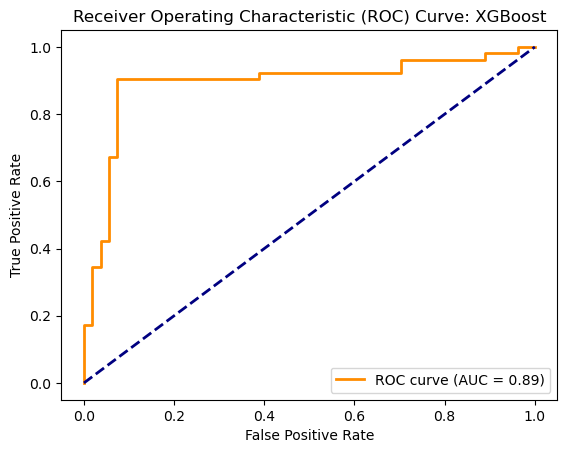

AUC: 0.8928


In [24]:
## YOUR CODE HERE
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2 , label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: XGBoost')
plt.legend(loc="lower right")
plt.show()

# Print the AUC
print(f"AUC: {roc_auc:.4f}")


#### Compare the results of the XGBoost model with the Ridge and the Lasso models and report your findings.

<!-- * AUC ROC for Ridge Regression is 0.913
* AUC ROC for Lasso Regression is 0.919
* AUC ROC for XGBoost model with L2 regularization is 0.89
* Optimal $\alpha$ is 1 for Ridge Regression
* Optimal $\alpha$ is 0.01 for Lasso Regression
* Optimal $\alpha$ is 0.001 for XGBoost with L2 regularization -->

|Model| AUC ROC| Optimal $\alpha$|
|-----|-----|----|
|Ridge Regression|0.913|1|
|Lasso Regression|0.919|0.01|
|XGBoost with L2 regularization|0.892|0.001|
 
#### Findings:
* Both Ridge and Lasso Regression models outperform the XGBoost model with L2 regularization in terms of AUC ROC. Lasso Regression has the highest AUC ROC (0.919), followed closely by Ridge Regression (0.913). This is an indication that feature selection is a good step for the given dataset.
* Ridge and Lasso Regressions are linear regression techniques that often perform well when dealing with a moderate number of features and linear relationships. They may provide good results when the relationships between features and the target variable are approximately linear.
* The XGBoost model with L2 regularization, while a powerful ensemble method, seems to have lower predictive performance in this specific scenario compared to linear regression techniques. It's possible that the XGBoost model's complexity and regularization settings may not be well-suited for the given dataset and problem, leading to lower AUC ROC values.
* It might also be the case that AUC ROC is not the best evaluation metrics for XGBoost model.
* The optimal hyperparameters for Ridge and Lasso Regression models are significantly different from the optimal $\alpha$ value for the XGBoost model with L2 regularization. This suggests that the degree of regularization required in the Ridge and Lasso models differs from that in the XGBoost model.